In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from   IPython.display import clear_output

In [2]:
from   sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
from sklearn.neural_network import MLPClassifier
# from sklearn.kdatasets import make_classification
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Redes Neuronales (sklearn)

En la práctica se usa esta implementación de Redes Neuoronales


https://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised

In [4]:
def print_confusion(dt,ds,show_heatmap=0,Cnorm=1):
    # dt - true, ds - predicted
    C   = confusion_matrix(dt,ds) 
    print('Confusion Matrix:')
    print(C)
    acc = accuracy_score(dt,ds) 
    acc_st = "{:.2f}".format(acc*100)
    print('Accuracy = '+str(acc_st))
    if show_heatmap:
      sns.heatmap(C/Cnorm, annot=True, cbar=None, cmap="Blues")
      plt.title("Confusion Matrix"), plt.tight_layout()
      plt.ylabel("True Class"), plt.xlabel("Predicted Class")
      plt.show()

def plot_features(X,d,st,show=1):
    dmin = int(np.min(d)) 
    dmax = int(np.max(d)) 
    #colors = np.array(["red","green","blue","yellow","pink","black","orange","purple","beige","brown","gray","cyan","magenta"])
    #colors = 'Greens'
    for j in range(dmin,dmax+1):
        plt.scatter(X[d==j,0],X[d==j,1],label=str(j),s=27)
    plt.grid(True)
    plt.legend()
    plt.xlabel('$x_1$',fontsize=14)
    plt.ylabel('$x_2$',fontsize=14)
    plt.title('Feature Space - '+st,fontsize=14)
    if show==1:
        plt.show()

def plot_decision_lines(clf,X,show=0,decisionline=1):
    # based on example of https://scikit-learn.org
    h = 0.075
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    if decisionline == 1:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Reds, alpha=0.8)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    if show==1:
        plt.show()

def show_clf_results(clf,X,d,Xt,dt,d0,ds,st,decisionline=1):
    gs = gridspec.GridSpec(1, 2)
    fig = plt.figure(figsize=(18, 6))
    print('Training:')
    acc = accuracy_score(d,d0) 
    accst = f'Acc = {acc:.4f}'    
    ax = plt.subplot(gs[0,0])
    print_confusion(d,d0)                             # confusion matrix in training
    plot_decision_lines(clf,X,0,decisionline)          # decision lines
    plot_features(X,d,st+' - Training: '+accst,0)     # feature space in training   
    ax = plt.subplot(gs[0,1])
    print('Testing:')
    acc = accuracy_score(ds,dt) 
    accst = f'Acc = {acc:.4f}'    
    print_confusion(dt,ds)                            # confusion matrix in testing
    plot_decision_lines(clf,X,0,decisionline)          # decision lines
    plot_features(Xt,dt,st+' - Testing: '+accst,1)    # feature space in testing


def plot_loss(loss_train):
    plt.figure(figsize=[8,6])
    plt.plot(loss_train,'r',linewidth=1.5)
    # plt.plot(loss_val,'b',linewidth=1.5)
    # plt.legend(['Training loss', 'Validation Loss'],fontsize=14)
    plt.xlabel('Epochs ',fontsize=14)
    plt.ylabel('Loss',fontsize=14)
    plt.title('Training Loss',fontsize=14)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(0,xmax)
    plt.ylim(0,ymax)
    plt.grid(True)
    plt.show()

# Plataformas


In [5]:
class VideoGames:
  def __init__(self, filename,
               cols:list = ['Length.Completionists.Median', 'Metrics.Used Price'], # 'release_year', 
              #  colsF:list = ['age_certification'], #,'genres' 'age_certification', 
               label = 'Metrics.Review Score',
               labelSubd = (0,100,25), #(0,100,10), # (min,max,step) # or None
               ptrain = 0.8 #,
              #  cols_drop = ['description','seasons','imdb_id','tmdb_popularity','imdb_votes','tmdb_score']
              ):
    self.filename = f'data/{filename}.csv'
    self.df_ini = pd.read_csv(self.filename)
    # self.df_ini['Metrics.Used Price'] = self.df_ini['Length.All PlayStyles.Median'].fillna('APT')

    cols_drop = []
    for c in self.df_ini.columns:
      if c not in cols+[label]: cols_drop += [c]
    self.df = self.df_ini.drop(columns=cols_drop)
    self.df = self.df.dropna().drop_duplicates()

    self.cols = cols
    # si usamos columnas categoricas, se deben convertir a int
    for c in cols:
      if self.df.dtypes[c] == object:
        # print('obj')
        le = LabelEncoder()
        le.fit(self.df[c])
        # list(le.classes_)
        self.df[f'{c}_bk'] = self.df[c]
        self.df[c] = le.transform(self.df[c])
        # self.cols += [f'{c}_n']
    
    if labelSubd != None:
      _min, _max, _step = labelSubd
      bins = np.arange(_min, _max+1, _step)
      names = np.arange( (_max - _min)/_step, dtype=int )
      self.df.loc[self.df[label] > _max, label] = _max
      self.df[f'{label}_bk'] = self.df[label]
      self.df[label] = pd.cut(self.df[label], bins, labels=names)      

    self.n = len(self.df)
    self.n_train = int( self.n * ptrain )
    # self.n_test = self.n - self.n_test
    # df_dm[['release_year', 'age_certification', 'runtime', 'genres']]
    self.x_train = np.array(self.df[self.cols][:self.n_train])
    self.y_train = np.ravel(self.df[label][:self.n_train])#.astype('float')
    # self.y_train = np.floor(self.y_train)
    self.x_test = np.array(self.df[self.cols][self.n_train+1:])
    self.y_test = np.ravel(self.df[label][self.n_train+1:])#.astype('float')
    # self.y_test = np.floor(self.y_test)

## VideoGames


In [6]:
vg = VideoGames('video_games')

In [7]:
vg.x_train

array([[30.        , 24.95      ],
       [ 0.        , 14.95      ],
       [ 7.25      , 22.95      ],
       ...,
       [17.        , 16.95      ],
       [13.5       , 16.95      ],
       [39.16666667, 17.95      ]])

In [8]:
vg.y_test

array([3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 2, 1, 3, 2, 3, 2, 3, 2, 2, 3, 2,
       3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 1, 3,
       3, 3, 3, 3, 3, 1, 2, 1, 3, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 2, 2, 2, 1, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 2, 2,
       1, 2, 3, 2, 1, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2,
       2, 1, 2, 3, 1, 2, 3, 1, 2, 3, 3, 1, 3, 3, 1, 3, 2, 2, 3, 2, 1, 1,
       3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2,
       2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1])

In [9]:
vg.df #.dtypes['id'] == object #['Features.Handheld?'] #tmdb_popularity

,Metrics.Review Score,Metrics.Used Price,Length.Completionists.Median,Metrics.Review Score_bk
0,3,24.95,30.000000,85
1,3,14.95,0.000000,89
2,3,22.95,7.250000,81
3,3,12.95,0.000000,81
4,2,14.95,72.566667,61
...,...,...,...,...
1206,2,12.95,12.866667,67
1207,2,17.95,12.000000,71
1209,2,15.95,0.000000,51
1210,2,17.95,12.000000,64


In [10]:
print(len(vg.x_train), len(vg.x_test))

750 187


In [11]:
# Definitions
alpha       = 1e-5          # learning rate
nh          = (4,2)        # nodes of hidden layers
tmax        = 2000          # max number of iterations
solver      = 'adam'        # optimization approach ('lbfgs','sgd', 'adam') 
nn_st       = 'NN-'+str(nh)
activation  = 'logistic'    # 'identity', 'logistic', 'tanh', 'relu'

# Training
clf = MLPClassifier(solver=solver, alpha=alpha, hidden_layer_sizes=nh, random_state=1, max_iter=tmax, activation=activation)
clf.fit(vg.x_train, vg.y_train)

# Evaluation on training subset 
y0 = clf.predict(vg.x_train)
    
# Evaluation on testing subset 
ypred = clf.predict(vg.x_test)

In [12]:
# clf,X,d,Xt,dt,d0,ds,st,decisionline=1
# show_clf_results(clf, Xtrain, ytrain, Xtest, ytest, y0, ypred, nn_st, decisionline=1)

Training:
Confusion Matrix:
[[  0   0   3   0]
 [  0   0  61   8]
 [  0   0 289 104]
 [  0   0 155 130]]
Accuracy = 55.87
Testing:
Confusion Matrix:
[[ 0 23  1]
 [ 0 75 27]
 [ 0 25 36]]
Accuracy = 59.36


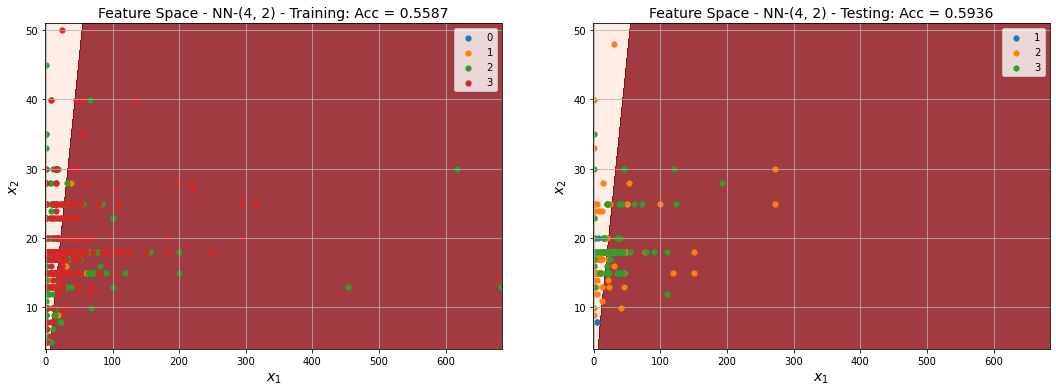

In [13]:
# Display results 
show_clf_results(clf, vg.x_train, vg.y_train, vg.x_test, vg.y_test, y0, ypred, nn_st, decisionline=1)